In [1]:
base = "/data_nfs/"

In [2]:
#from pytorch_grad_cam import GradCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2 
import sys
import os
from sklearn.mixture import GaussianMixture
import seaborn as sns

sys.path.append(os.path.join(base, "je30bery/melanoma_data/MAGICAL/model/"))
from data import MelanomaData
import numpy as np
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import pickle
import pandas as pd
plt.style.use('dark_background')
os.environ["CUDA_VISIBLE_DEVICES"]="1"
sys.path.append("../data_utils")
from data_utils import *
sys.path.append("../roi_analysis")
from neighbor_graphs import *
sys.path.append(os.path.join(base, "je30bery/melanoma_data/MAGICAL/smoothgrad"))
from individual_channel_gradcam import GradCAM

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
rois = [os.path.splitext(f)[0][7:] for f in os.listdir(os.path.join(base, "je30bery/melanoma_data/ROI/filled")) if "filled" in f]

In [5]:
data = get_data_csv(base)
data = data[data["file_path"].isin(rois)]
data = data.reset_index()

In [6]:
def in_over_all(a, b):
    in_roi = np.sum(np.logical_and(a, b))
    all = np.sum(a > 0)
    return in_roi/all

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_1897276/3361530244.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return in_roi/all
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


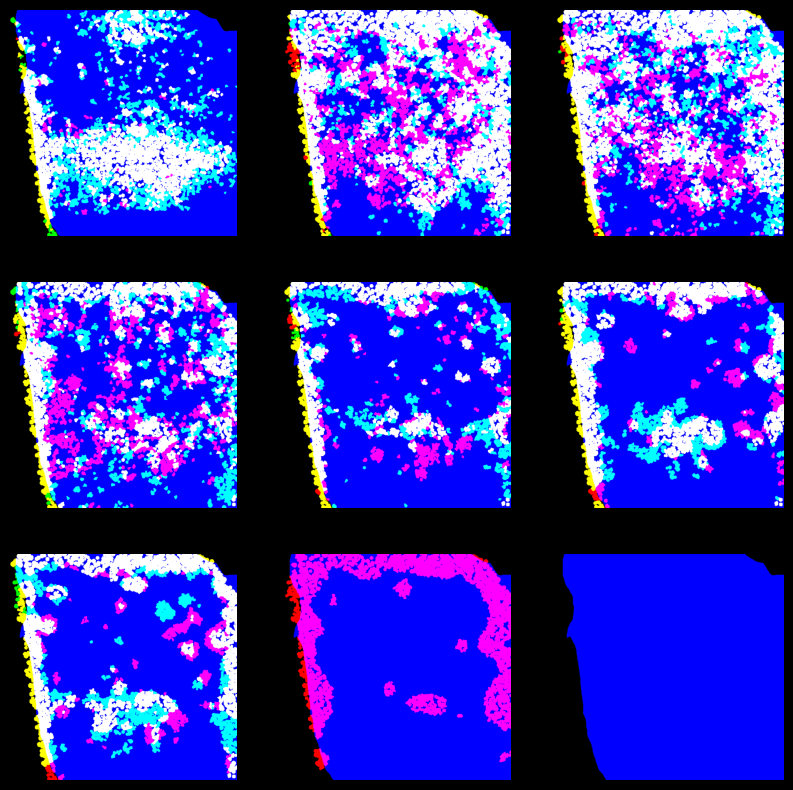

Proceed 


In [7]:
ious = pd.DataFrame()
ne = NeighborEnricher(None, base)
for d in range(len(data)):
    fov = data.iloc[d]["file_path"]
    segmented = os.path.join(base, "datasets/melc/melanoma/", "segmented", f'{fov}_cells.npy')
    with open(segmented, "rb") as openfile:
        seg_file = np.load(openfile)

    roi = cv2.imread(os.path.join(base, f"je30bery/melanoma_data/ROI/filled/filled_{fov}.tif"), cv2.IMREAD_GRAYSCALE)
    roi = cv2.resize(roi, (512, 512))
    if d == 5:
        roi = (roi > 15).astype(float)
    else:
        roi = (roi > 0).astype(float)
    
    f, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i, layer in enumerate(["0", "1", "2", "3", "4", "5", "6", "7", "8"]):
        binary = np.isin(seg_file, ne.get_roi_cells(fov, layer=layer, model="classification_model")[1:])
        binary_reg = np.isin(seg_file, ne.get_roi_cells(fov, layer=layer, model="regression_model")[1:])

        binary = cv2.resize((binary * 255).astype(np.uint8), (512, 512))
        binary_reg = cv2.resize((binary_reg * 255).astype(np.uint8), (512, 512))

        ious.loc[d, layer] = in_over_all(binary, roi)
        ious.loc[d, layer+ "_reg"] = in_over_all(binary_reg, roi)

        
        rgb = np.array([binary, binary_reg, roi]).transpose((1, 2, 0))
        axs[i // 3, i % 3].imshow(rgb)
        axs[i // 3, i % 3].axis("off")

    plt.show()
    _ = input("Proceed")
    
    clear_output(wait=True)

<Axes: >

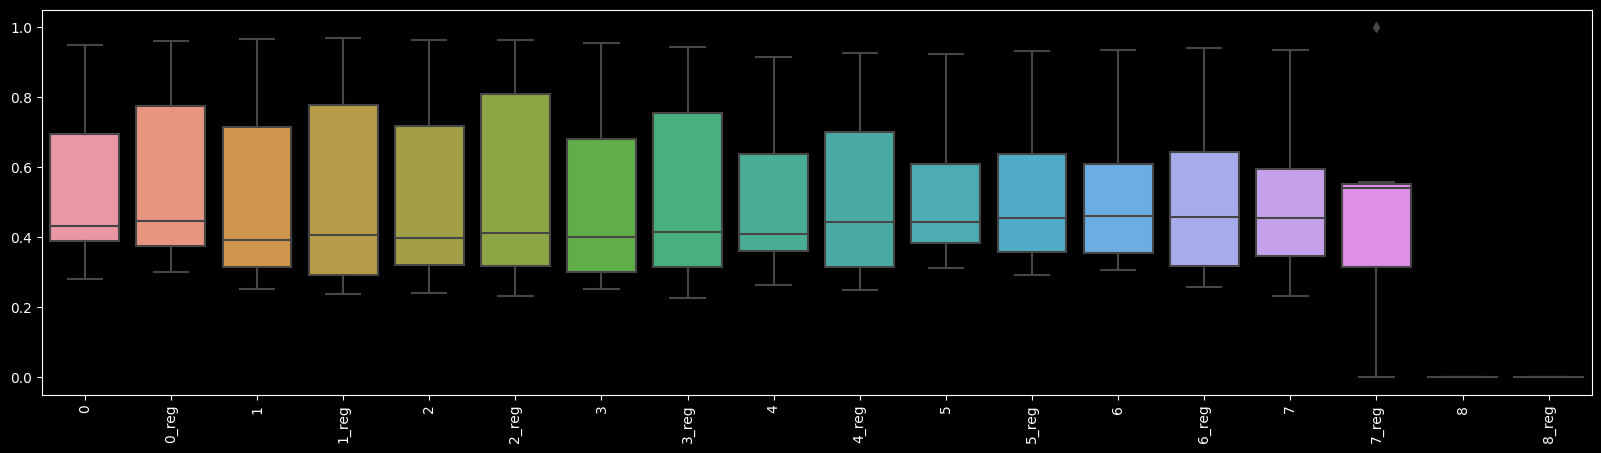

In [14]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
sns.boxplot(ious)

In [15]:
ious.mean(axis=0)

0        0.533994
0_reg    0.557780
1        0.503471
1_reg    0.522760
2        0.506986
2_reg    0.532461
3        0.503557
3_reg    0.516383
4        0.510338
4_reg    0.519243
5        0.530823
5_reg    0.524610
6        0.526054
6_reg    0.515804
7        0.520736
7_reg    0.466918
8        0.000000
8_reg    0.000000
dtype: float64